In [48]:
import pandas as pd
import os
# key_path = f'{os.getcwd()}/private_dir/gcp_key_path.txt'
# with open(key_path,'r') as f:
#     r = f.read().strip()

In [50]:
import db_dtypes
from google.cloud import bigquery
from google.oauth2 import service_account
# credential = service_account.Credentials.from_service_account_file()
client = bigquery.Client()

query = """
    SELECT *
    FROM `estate-project-382208.tmp.test2`
"""

results = client.query(query).to_dataframe()

# table_ref = client.dataset('tmp').table('test2')
# rows = client.list_rows(table_ref)
# results= rows.to_dataframe()
# Retrieve the table data as a pandas dataframe
# df = client.get_table(table_ref).to_dataframe(dtypes=db_dtypes.DEFAULT_SQL_DTYPE_MAPPING)

In [51]:
print(results.shape)
print(results.columns)

(8842, 18)
Index(['construction_company', 'use_approve', 'detail_addrs', 'addrs',
       'apt_code', 'no', 'apt_name', 'estate_name', 'trade_name',
       'supply_area', 'exclusive_area', 'direction', 'confirmYmd', 'latitude',
       'longitude', 'price', 'total_floor', 'current_floor'],
      dtype='object')


### 중복 데이터 제거

In [54]:
results.drop_duplicates(subset=['no'],keep='last',inplace=True)

### 건설사 명 통일

In [14]:
results.construction_company.value_counts()

(주)포스코건설             1731
(주)대우건설               509
(주)호반건설               466
주식회사포스코건설             411
현대건설(주)               346
대림산업(주)               222
에스케이건설(주)             181
지에스건설(주)              180
주식회사 포스코건설            111
롯데건설,대우건설 외 컨소시엄      102
풍림산업주식회사               89
풍림산업(주)                89
롯데건설주식회사 외 3사          78
지에스건설(주)외 3            67
에이치디씨현대산업개발(주)         57
대방건설(주),대방산업개발(주)      49
(주)현대산업개발              41
주식회사 대우건설              36
unknown                34
금호산업(주)                30
인천도시개발공사,(주)현진         28
주식회사 한진중공업             26
성지건설 주식회사              26
(주)한진중공업               23
롯데건설(주)                23
대경종합건설(주)              20
대양종합건설(주)              17
코오롱글로벌(주)              16
코오롱건설(주)               14
SK에코플랜트(주)             12
대경종합건설주식회사             11
(주)창보종합건설               6
위드종합건설(주)               3
Name: construction_company, dtype: int64

In [15]:
def preprocessing(row) :
    rm_texts = ['주식회사','(주)']
    for t in rm_texts:
        if t in row :
            row= row.replace(t,'')
    return row.strip()
    
results['construction_company'] = results['construction_company'].apply(lambda row : preprocessing(row))

In [16]:
results.construction_company.value_counts()

포스코건설               2253
대우건설                 545
호반건설                 466
현대건설                 346
대림산업                 222
에스케이건설               181
지에스건설                180
풍림산업                 178
롯데건설,대우건설 외 컨소시엄     102
롯데건설 외 3사             78
지에스건설외 3              67
에이치디씨현대산업개발           57
대방건설,대방산업개발           49
한진중공업                 49
현대산업개발                41
unknown               34
대경종합건설                31
금호산업                  30
인천도시개발공사,현진           28
성지건설                  26
롯데건설                  23
대양종합건설                17
코오롱글로벌                16
코오롱건설                 14
SK에코플랜트               12
창보종합건설                 6
위드종합건설                 3
Name: construction_company, dtype: int64

In [17]:
results[results['construction_company'].isna()]

,construction_company,use_approve,detail_addrs,addrs,apt_code,no,apt_name,estate_name,trade_name,supply_area,exclusive_area,direction,confirmYmd,latitude,longitude,price,total_floor,current_floor


In [18]:
results['use_approve'].value_counts()

20171117    360
20150729    244
20200713    234
20181106    222
20170201    191
           ... 
20170512     11
202111       11
20211122     10
20220511     10
20060210      3
Name: use_approve, Length: 65, dtype: Int64

In [19]:
results.loc[results['use_approve'].apply(lambda row : len(str(row)) > 8),'use_approve']

Series([], Name: use_approve, dtype: Int64)

### 아파트 명 전처리

In [20]:
results['apt_name'].value_counts()

더샵송도마리나베이              234
e편한세상송도                222
베르디움더퍼스트               191
송도더샵센트럴시티              162
송도SK뷰                  160
                      ... 
송도코오롱더프라우2단지(주상복합)       6
송도풍림아이원3단지               6
송도센트럴파크리버리치              6
송도푸르지오월드마크1단지(주상복합)      5
위드프리상뜨(주상복합)             3
Name: apt_name, Length: 86, dtype: int64

In [52]:
results[results['apt_name']=='None']

,construction_company,use_approve,detail_addrs,addrs,apt_code,no,apt_name,estate_name,trade_name,supply_area,exclusive_area,direction,confirmYmd,latitude,longitude,price,total_floor,current_floor


In [22]:
import re
import traceback

def rm_bracket(row:str) :
    rm_char=''
    pat = re.compile('\(\S+\)')
    rm_char = pat.search(row)
    if rm_char is not None:
        row = row.replace(rm_char.group(),'')
    return row.strip()


results['apt_name']= results['apt_name'].apply(lambda row : rm_bracket(str(row)))
# print(a)


In [23]:
results['apt_name'].value_counts()

송도더샵퍼스트파크        360
송도더샵마스터뷰         244
더샵송도마리나베이        234
e편한세상송도          222
베르디움더퍼스트         191
                ... 
송도풍림아이원3단지         6
송도센트럴파크리버리치        6
송도코오롱더프라우2단지       6
송도푸르지오월드마크1단지      5
위드프리상뜨             3
Name: apt_name, Length: 81, dtype: int64

# EDA

In [15]:
import matplotlib as mpl
import matplotlib.font_manager as fm
print ('버전: ', mpl.__version__)
print ('설치 위치: ', mpl.__file__)
print ('설정 위치: ', mpl.get_configdir())
print ('캐시 위치: ', mpl.get_cachedir())
font_list = fm.findSystemFonts(fontpaths=None, fontext='ttf')
[i for i in font_list if 'nanum' in i.lower()]

버전:  3.7.1
설치 위치:  /home/song/v_env/gcp_env/lib/python3.10/site-packages/matplotlib/__init__.py
설정 위치:  /home/song/.config/matplotlib
캐시 위치:  /home/song/.cache/matplotlib


['/usr/share/fonts/nanum/NanumBarunGothicUltraLight.otf',
 '/usr/share/fonts/nanum/NanumBarunGothicBold.ttf',
 '/usr/share/fonts/nanum/NanumMyeongjoBold.ttf',
 '/usr/share/fonts/nanum/NanumBarunGothicUltraLight.ttf',
 '/usr/share/fonts/nanum/NanumPen.ttf',
 '/usr/share/fonts/nanum/NanumBrush.ttf',
 '/usr/share/fonts/nanum/NanumBarunGothicBold.otf',
 '/usr/share/fonts/nanum/NanumBarunGothic.otf',
 '/usr/share/fonts/nanum/NanumBarunGothic.ttf',
 '/usr/share/fonts/nanum/NanumMyeongjoExtraBold.ttf',
 '/usr/share/fonts/nanum/NanumGothic.ttf',
 '/usr/share/fonts/nanum/NanumMyeongjo.ttf',
 '/usr/share/fonts/nanum/NanumBarunGothicLight.ttf',
 '/usr/share/fonts/nanum/NanumBarunGothicLight.otf',
 '/usr/share/fonts/nanum/NanumGothicExtraBold.ttf',
 '/usr/share/fonts/nanum/NanumGothicBold.ttf']

### 현 매물들 가격

In [18]:
results[['apt_name','price']].groupby('apt_name').median().sort_values(by='price',ascending=False)

,price
apt_name,
더샵송도아크베이,132820.0
송도센트럴파크푸르지오,125000.0
송도자이하버뷰2단지,120000.0
힐스테이트송도더스카이,116500.0
더샵엑스포6단지,110000.0
...,...
송도대경스위트리아파크뷰,39000.0
호반써밋송도,37000.0
송도풍림아이원2단지,34000.0


In [19]:
cols = results[['apt_name','price']].groupby('apt_name').median().sort_values(by='price',ascending=False)

In [21]:
cols.index

Index(['더샵송도아크베이', '송도센트럴파크푸르지오', '송도자이하버뷰2단지', '힐스테이트송도더스카이', '더샵엑스포6단지',
       '송도국제도시디엠시티시그니처뷰', '송도풍림아이원6단지', '힐스테이트레이크송도4차', '송도자이더스타',
       '송도푸르지오월드마크7단지', '송도웰카운티4단지', '송도자이크리스탈오션', '송도코오롱더프라우2단지', '송도럭스오션SK뷰',
       '더샵센트럴파크2차', '더샵센트럴파크1차', '송도푸르지오하버뷰', '송도자이하버뷰1단지', '더샵엑스포9단지',
       '송도더샵14단지하버뷰', '송도더샵퍼스트월드', '송도푸르지오월드마크1단지', '송도더샵하버뷰II',
       '송도코오롱더프라우1단지', '송도해모로', '송도더샵13단지하버뷰', '힐스테이트레이크송도3차', '송도센트럴파크리버리치',
       '송도더샵마스터뷰', '송도더샵그린워크3차', '힐스테이트레이크송도2차', '송도더샵퍼스트파크', '송도웰카운티3단지',
       '송도SK뷰센트럴', '송도웰카운티1단지', '더샵그린스퀘어', '더샵엑스포10단지', '송도더샵8단지그린애비뉴',
       '송도해모로월드뷰', '송도SK뷰', '송도아이파크', '송도웰카운티2단지', '송도더샵센트럴파크3차', '더샵그린워크1차',
       '송도오션파크베르디움', '송도에듀포레푸르지오', '랜드마크시티센트럴더샵', '송도글로벌파크베르디움', '더샵송도마리나베이',
       '송도더샵7단지그린애비뉴', '롯데캐슬캠퍼스타운', '송도금호어울림', '베르디움더퍼스트', '송도더샵센트럴시티',
       '글로벌캠퍼스푸르지오', '송도더프라우3단지', '송도캐슬해모로', '송도풍림아이원4단지', 'e편한세상송도',
       '송도아트윈푸르지오', '인천송도힐스테이트', '송도풍림아이원1단지', '위드프리상뜨', '송도더샵파크애비뉴',
       '더샵그린워크2차', '더샵송도센터니얼', '힐스테이트레이크송도', '송도

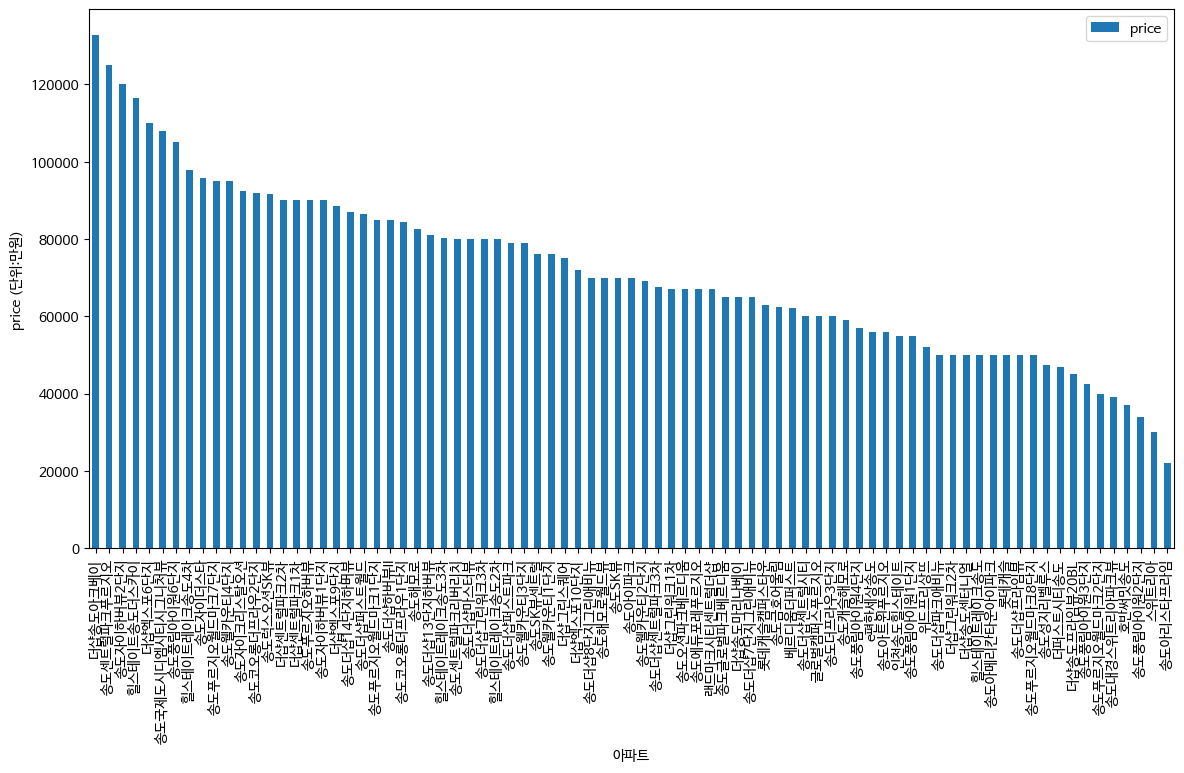

In [20]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

font_path = '/usr/share/fonts/nanum/NanumBarunGothic.ttf'
font_name = fm.FontProperties(fname=font_path).get_name()
plt.rc('font', family=font_name)
ax= results[['apt_name','price']].groupby('apt_name').median().sort_values(by='price',ascending=False).plot(kind='bar',figsize=(14,7))
ax.set_xticklabels(cols.index,rotation=90)
plt.ylabel('price (단위:만원)',fontproperties=font_name)
plt.xlabel('아파트',fontproperties=font_name)
plt.show()
# plt.xticks(rotation=45)
# plt.rcParams['font.family'] = 'NanumBarunGothic'

In [22]:
only_purchase = results[results['trade_name']=='매매']

In [ ]:
datetime.datetime.now().strftime('%Y%m%d')

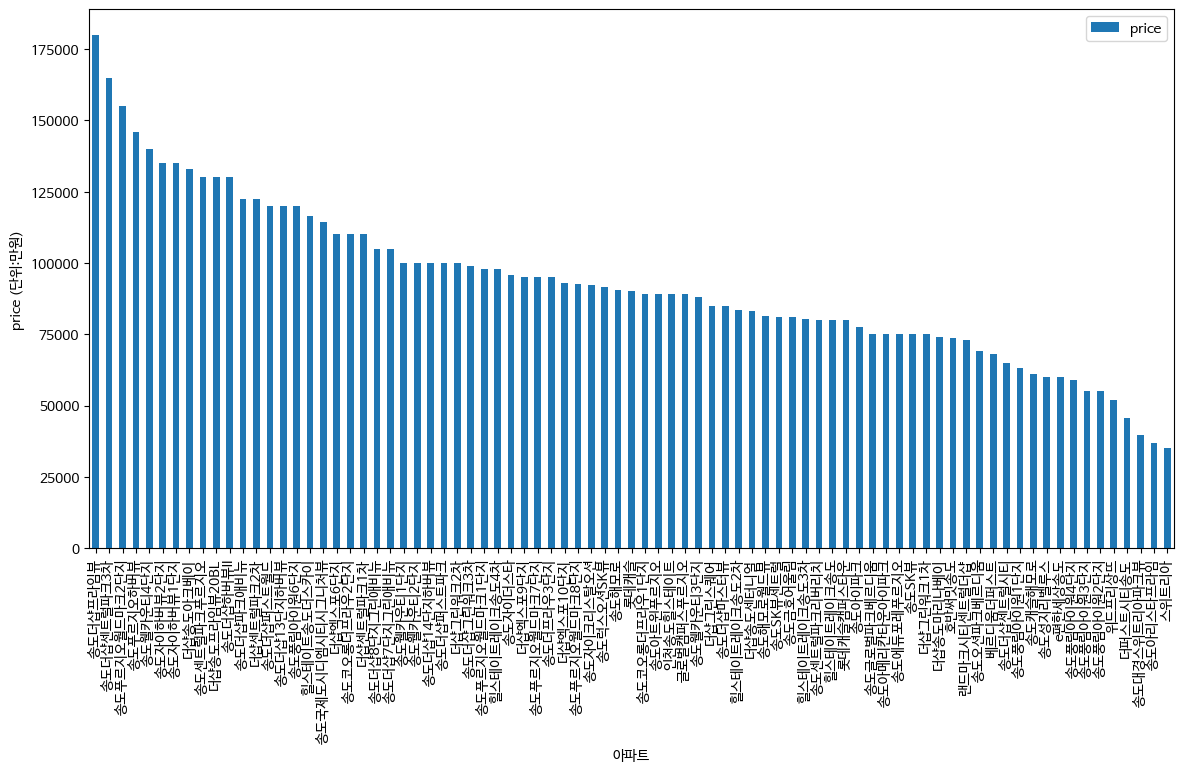

In [23]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

data = only_purchase[['apt_name','price']].groupby('apt_name').median().sort_values(by='price',ascending=False)
font_path = '/usr/share/fonts/nanum/NanumBarunGothic.ttf'
font_name = fm.FontProperties(fname=font_path).get_name()
plt.rc('font', family=font_name)
ax= data.plot(kind='bar',figsize=(14,7))
ax.set_xticklabels(data.index,rotation=90)
plt.ylabel('price (단위:만원)',fontproperties=font_name)
plt.xlabel('아파트',fontproperties=font_name)
plt.show()
# plt.xticks(rotation=45)
# plt.rcParams['font.family'] = 'NanumBarunGothic'

In [54]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

data = only_purchase[['apt_name','price']].groupby('apt_name').median().sort_values(by='price',ascending=False)
font_path = '/usr/share/fonts/nanum/NanumBarunGothic.ttf'
font_name = fm.FontProperties(fname=font_path).get_name()
plt.rc('font', family=font_name)
ax= data.plot(kind='bar',figsize=(14,7))
ax.set_xticklabels(data.index,rotation=90)
plt.ylabel('price (단위:만원)',fontproperties=font_name)
plt.xlabel('아파트',fontproperties=font_name)
plt.show()
# plt.xticks(rotation=45)
# plt.rcParams['font.family'] = 'NanumBarunGothic'

,price
apt_name,
송도코오롱더프라우2단지,230000.0
송도푸르지오월드마크2단지,210000.0
송도더샵프라임뷰,180000.0
송도더샵센트럴파크3차,165000.0
송도더샵하버뷰II,140000.0
...,...
위드프리상뜨,52000.0
송도대경스위트리아파크뷰,46000.0
더퍼스트시티송도,39116.5


In [66]:
results['use_approve']=results['use_approve'].apply(lambda row : int(str(row)[:4]))

In [67]:
results.corr()

,use_approve,apt_code,no,supply_area,exclusive_area,confirmYmd,latitude,longitude,price,total_floor
use_approve,1.000000,0.858420,-0.024186,-0.417475,-0.469572,0.011888,0.243527,-0.607989,-0.085991,0.429379
apt_code,0.858420,1.000000,-0.020892,-0.475937,-0.517145,0.026204,0.103977,-0.410109,-0.139357,0.308518
no,-0.024186,-0.020892,1.000000,0.017734,0.014479,0.725357,-0.019228,0.046061,0.015010,0.008431
supply_area,-0.417475,-0.475937,0.017734,1.000000,0.984863,-0.019165,-0.052477,0.188719,0.440558,-0.033584
exclusive_area,-0.469572,-0.517145,0.014479,0.984863,1.000000,-0.022188,-0.038156,0.197755,0.419867,-0.127525
confirmYmd,0.011888,0.026204,0.725357,-0.019165,-0.022188,1.000000,0.000900,0.001702,0.003037,0.020009
latitude,0.243527,0.103977,-0.019228,-0.052477,-0.038156,0.000900,1.000000,-0.656193,-0.057690,0.138436
longitude,-0.607989,-0.410109,0.046061,0.188719,0.197755,0.001702,-0.656193,1.000000,-0.027053,-0.252802
price,-0.085991,-0.139357,0.015010,0.440558,0.419867,0.003037,-0.057690,-0.027053,1.000000,0.081411
total_floor,0.429379,0.308518,0.008431,-0.033584,-0.127525,0.020009,0.138436,-0.252802,0.081411,1.000000


### 많이 나온 매물 

In [55]:
results.shape

(5054, 18)

In [56]:
results.columns

Index(['construction_company', 'use_approve', 'detail_addrs', 'addrs',
       'apt_code', 'no', 'apt_name', 'estate_name', 'trade_name',
       'supply_area', 'exclusive_area', 'direction', 'confirmYmd', 'latitude',
       'longitude', 'price', 'total_floor', 'current_floor'],
      dtype='object')

In [57]:
results['apt_name'].value_counts().sort_values()

위드프리상뜨(주상복합)             3
송도푸르지오월드마크1단지(주상복합)      5
송도풍림아이원3단지               6
송도센트럴파크리버리치              6
송도코오롱더프라우2단지(주상복합)       6
                      ... 
송도SK뷰                  160
송도더샵센트럴시티              162
베르디움더퍼스트               191
e편한세상송도                222
더샵송도마리나베이              234
Name: apt_name, Length: 86, dtype: int64

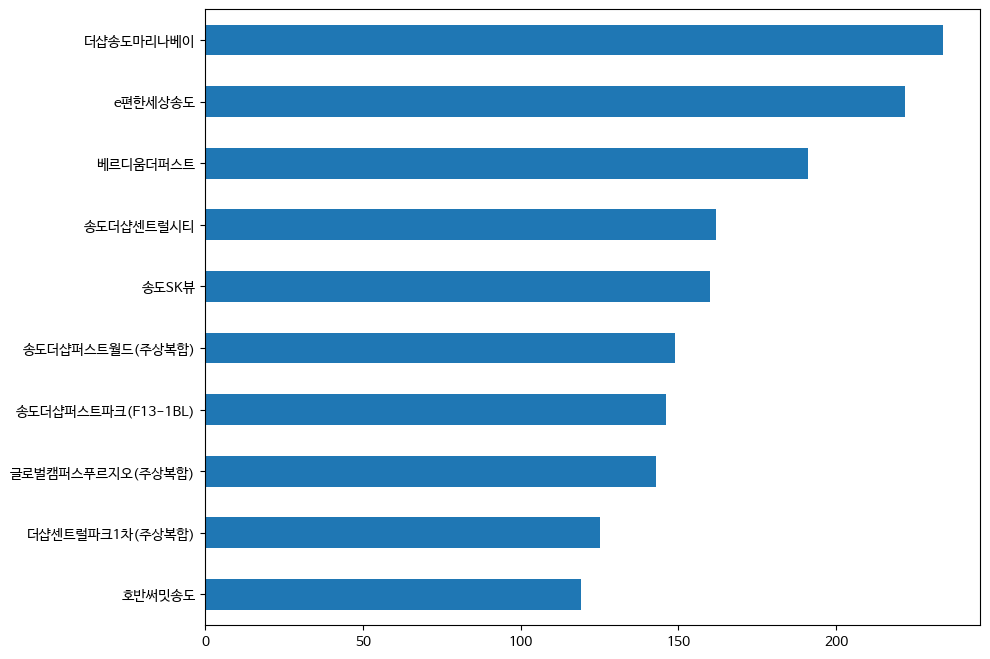

In [62]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

data = results['apt_name'].value_counts().sort_values().tail(10)
font_path = '/usr/share/fonts/nanum/NanumBarunGothic.ttf'
font_name = fm.FontProperties(fname=font_path).get_name()
plt.rc('font', family=font_name)
ax= data.plot(kind='barh',figsize=(10,8))
# ax.set_xticklabels(data.index,rotation=90)
# plt.ylabel('ea',fontproperties=font_name)
# plt.xlabel('아파트',fontproperties=font_name)
plt.show()
# plt.xticks(rotation=45)
# plt.rcParams['font.family'] = 'NanumBarunGothic'

In [69]:
results['direction'].value_counts()

남서향    1879
남동향    1865
남향      854
북서향     237
북동향     129
서향       57
동향       21
북향       12
Name: direction, dtype: int64

In [71]:
results['exclusive_area'].value_counts()

84     2042
101     360
59      239
70      143
95      129
       ... 
43        1
136       1
103       1
80        1
228       1
Name: exclusive_area, Length: 95, dtype: Int64

In [74]:
84/3.3

25.454545454545457